This code implements a transfer learning pipeline that fine-tunes a pre-trained multilingual sentence embedding model (LaBSE) for a semantic similarity task in Afrikaans. The objective is to predict how semantically related two sentences are on a continuous scale.

Experimental Design:
- The entire experiment is looped 10 times, each with a different random seed. This ensures that model performance is not the result of a particular initialization or train-test split. Results are averaged and analyzed across all runs to provide statistical robustness.

Data Processing:
- Missing/Duplicate Value Handling -  Removal
- Stratified Spliting (Train//Test Sets): to preserve label distribution from initial dataset across training/test sets.
- Data Format Conversion [sentene1][sentence2][label]

Exploratory Data Analysis:
- Label Distribution Analysis (Enhanced)
- Label Statistics Box Plot with Quartiles
- Score Range Analysis
- Sentence Length Analysis
- Length Difference vs Similarity
- Word Count Analysis
- Correlation Heatmap of Numerical Features
- Similarity Score by Length Quartiles
- Character-level Analysis (special characters, digits, etc.)
- Outlier Analysis
- High vs Low Similarity Examples Analysis
- Dataset Balance Analysis
- High similarity word cloud
- Low similarity word cloud

Transfer Learning Strategy:
- Base Model: LaBSE (Language-Agnostic BERT Sentence Embeddings)
  - Pre-trained Foundation: LaBSE is already trained on massive multilingual text data
  - Existing Knowledge: It already understands language structure, syntax, and basic semantics
- Transfer Learning Benefit: Instead of training from scratch, we adapt this existing knowledge

Fine-tuning Process:
- Load Pre-trained Model:
- Parameter tuning:
  - Seed
  - Batch Size
  - Epochs
  - Learning rate
  - Evaluation Steps (Iterations)

Model evaluation:
- The model lose fuction is cosine similarity as the final similarity measure
- Task-Specific Training: Fine-tune on your specific sentence pair dataset with similarity scores

Evaluation Metrics:
- Pearson Correlation
- Spearman Correlation
- Mean Square Error (MSE)
- Mean Absolute error (MAE)


Model Interpretability: LIME Visualizations:
- To improve trust and explainability of the model, we integrate LIME (Local Interpretable Model-agnostic Explanations) into the pipeline:
  - Sentence 1 Feature Importance:
    LIME highlights which words in Sentence 1 contribute most to the predicted similarity score.
  - Sentence 2 Feature Importance:
    A parallel analysis for Sentence 2’s individual word contributions.
  - Combined Importance Comparison:
    A merged view comparing feature importance scores from both sentences, illustrating cross-sentence contributions.
  - Highlighted Text Visualization:
    Color-coded visual overlays show the influence of each word on the final similarity prediction. Green may indicate positive contribution, red negative, with intensity indicating magnitude.

# Imports, Configurations and Seeding

In [ ]:
!pip install sentence-transformers torch torchvision scikit-learn scipy pandas numpy
!pip install textstat
!pip install lime

import pandas as pd
import numpy as np
import random
import os

import torch
torch.cuda.empty_cache()

from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline
import re
from collections import defaultdict


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_DISABLED"] = "true"

# Check if we're in Colab and mount Google Drive (optional)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except ImportError:
    print("Not running in Google Colab or Drive mount not needed")

# Verify GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("GPU not available - make sure to enable GPU in Runtime > Change runtime type")


# Configuration
BASE_SEED = 42
NUM_RUNS = 10
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

def set_all_seeds(seed):
    """Set seeds for all random number generators to ensure reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"All seeds set to {seed}")

def setup_device():
    """Setup and display device information"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"🔥 Current GPU memory usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

        # Clear GPU cache
        torch.cuda.empty_cache()
        print("🧹 GPU cache cleared")
    else:
        device = torch.device('cpu')
        print("⚠️ GPU not available, using CPU")
        print("💡 To enable GPU: Runtime > Change runtime type > Hardware accelerator > GPU")
    return device

# Data Loading and Preparation

In [ ]:
def load_and_prepare_dataset(file_path):
    """Load dataset with basic preparation"""
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    df = None

    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Successfully loaded dataset with {encoding} encoding")
            break
        except Exception as e:
            continue

    if df is None:
        raise ValueError("❌ Could not load the file with any encoding")

    print(f"\n📊 Dataset Information:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")

    # Clean dataset
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
        print("🧹 Removed 'Unnamed: 0' column")

    # Handle missing values
    initial_size = len(df)
    df = df.dropna()
    removed_rows = initial_size - len(df)
    if removed_rows > 0:
        print(f"🧹 Removed {removed_rows} rows with missing values")

    print(f"📏 Final dataset shape: {df.shape}")
    return df

# Updated split_dataset function for 70/30 split
def split_dataset(df, train_size=0.7, test_size=0.3, seed=42):
    """Split dataset into train/test sets (70/30)"""
    print(f"\n🔄 Splitting dataset with seed {seed}:")
    print(f"   Train: {train_size:.1%}, Test: {test_size:.1%}")

    # Simple train-test split
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=seed,
        shuffle=True
    )

    print(f"📊 Split Results:")
    print(f"   Train set: {len(train_df)} samples")
    print(f"   Test set: {len(test_df)} samples")

    return train_df, test_df

def prepare_examples(df):
    """Convert dataframe to InputExample format"""
    examples = []
    for _, row in df.iterrows():
        example = InputExample(
            texts=[str(row['sentence1']), str(row['sentence2'])],
            label=float(row['label'])
        )
        examples.append(example)
    return examples

# Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re
from wordcloud import WordCloud
from textstat import flesch_reading_ease, flesch_kincaid_grade
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def enhanced_eda_semantic_similarity(df):
    """
    Comprehensive EDA specifically designed for semantic similarity datasets
    """
    print("🔍 ENHANCED EXPLORATORY DATA ANALYSIS")
    print("=" * 50)

    # Basic dataset info (keeping your existing ones)
    print(f"\n📊 Dataset Overview:")
    print(f"   Total samples: {len(df):,}")
    print(f"   Features: {list(df.columns)}")
    print(f"   Data types: {dict(df.dtypes)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 24))

    # 1. Label Distribution Analysis (Enhanced)
    ax1 = plt.subplot(4, 3, 1)
    plt.hist(df['label'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(df['label'].mean(), color='red', linestyle='--', label=f'Mean: {df["label"].mean():.3f}')
    plt.axvline(df['label'].median(), color='green', linestyle='--', label=f'Median: {df["label"].median():.3f}')
    plt.title('Similarity Score Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Label Statistics Box Plot with Quartiles
    ax2 = plt.subplot(4, 3, 2)
    box_plot = plt.boxplot(df['label'], vert=True, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    plt.title('Similarity Score Distribution\n(Box Plot)', fontsize=12, fontweight='bold')
    plt.ylabel('Similarity Score')

    # Add quartile annotations
    q1, median, q3 = df['label'].quantile([0.25, 0.5, 0.75])
    plt.text(1.15, q1, f'Q1: {q1:.3f}', fontsize=10)
    plt.text(1.15, median, f'Median: {median:.3f}', fontsize=10)
    plt.text(1.15, q3, f'Q3: {q3:.3f}', fontsize=10)

    # 3. Score Range Analysis
    ax3 = plt.subplot(4, 3, 3)
    score_ranges = pd.cut(df['label'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    score_counts = score_ranges.value_counts()
    colors = ['#ff9999', '#ffcc99', '#ffff99', '#ccff99', '#99ff99']
    plt.pie(score_counts.values, labels=score_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Similarity Score Ranges', fontsize=12, fontweight='bold')

    # 4. Sentence Length Analysis
    df['len1'] = df['sentence1'].astype(str).apply(len)
    df['len2'] = df['sentence2'].astype(str).apply(len)
    df['len_diff'] = abs(df['len1'] - df['len2'])

    ax4 = plt.subplot(4, 3, 4)
    plt.scatter(df['len1'], df['len2'], alpha=0.6, c=df['label'], cmap='viridis')
    plt.colorbar(label='Similarity Score')
    plt.xlabel('Sentence 1 Length (characters)')
    plt.ylabel('Sentence 2 Length (characters)')
    plt.title('Sentence Lengths vs Similarity', fontsize=12, fontweight='bold')
    plt.plot([0, max(df[['len1', 'len2']].max())], [0, max(df[['len1', 'len2']].max())], 'r--', alpha=0.5)

    # 5. Length Difference vs Similarity
    ax5 = plt.subplot(4, 3, 5)
    plt.scatter(df['len_diff'], df['label'], alpha=0.6, color='coral')
    plt.xlabel('Length Difference (characters)')
    plt.ylabel('Similarity Score')
    plt.title('Length Difference vs Similarity', fontsize=12, fontweight='bold')

    # Add trend line
    z = np.polyfit(df['len_diff'], df['label'], 1)
    p = np.poly1d(z)
    plt.plot(df['len_diff'], p(df['len_diff']), "r--", alpha=0.8)

    # 6. Word Count Analysis
    df['words1'] = df['sentence1'].astype(str).apply(lambda x: len(x.split()))
    df['words2'] = df['sentence2'].astype(str).apply(lambda x: len(x.split()))
    df['word_diff'] = abs(df['words1'] - df['words2'])

    ax6 = plt.subplot(4, 3, 6)
    plt.hist([df['words1'], df['words2']], bins=20, alpha=0.7, label=['Sentence 1', 'Sentence 2'])
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title('Word Count Distribution', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 7. Correlation Heatmap of Numerical Features
    ax7 = plt.subplot(4, 3, 7)
    numeric_features = ['label', 'len1', 'len2', 'len_diff', 'words1', 'words2', 'word_diff']
    corr_matrix = df[numeric_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, ax=ax7)
    plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

    # 8. Similarity Score by Length Quartiles
    ax8 = plt.subplot(4, 3, 8)
    df['len1_quartile'] = pd.qcut(df['len1'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    sns.boxplot(data=df, x='len1_quartile', y='label', ax=ax8)
    plt.title('Similarity by Sentence 1 Length Quartiles', fontsize=12, fontweight='bold')
    plt.xlabel('Length Quartile')
    plt.ylabel('Similarity Score')

    # 9. Character-level Analysis (special characters, digits, etc.)
    def analyze_text_composition(text):
        text = str(text)
        return {
            'alpha_ratio': sum(c.isalpha() for c in text) / len(text) if len(text) > 0 else 0,
            'digit_ratio': sum(c.isdigit() for c in text) / len(text) if len(text) > 0 else 0,
            'space_ratio': sum(c.isspace() for c in text) / len(text) if len(text) > 0 else 0,
            'punct_ratio': sum(not c.isalnum() and not c.isspace() for c in text) / len(text) if len(text) > 0 else 0
        }

    # Apply analysis to both sentences
    composition1 = df['sentence1'].apply(analyze_text_composition)
    composition2 = df['sentence2'].apply(analyze_text_composition)

    ax9 = plt.subplot(4, 3, 9)
    comp_df = pd.DataFrame([
        {'Sentence': 'Sentence 1', 'Alpha': np.mean([c['alpha_ratio'] for c in composition1]),
         'Digit': np.mean([c['digit_ratio'] for c in composition1]),
         'Space': np.mean([c['space_ratio'] for c in composition1]),
         'Punctuation': np.mean([c['punct_ratio'] for c in composition1])},
        {'Sentence': 'Sentence 2', 'Alpha': np.mean([c['alpha_ratio'] for c in composition2]),
         'Digit': np.mean([c['digit_ratio'] for c in composition2]),
         'Space': np.mean([c['space_ratio'] for c in composition2]),
         'Punctuation': np.mean([c['punct_ratio'] for c in composition2])}
    ])

    comp_df.set_index('Sentence')[['Alpha', 'Digit', 'Space', 'Punctuation']].plot(kind='bar', ax=ax9)
    plt.title('Text Composition Analysis', fontsize=12, fontweight='bold')
    plt.ylabel('Ratio')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 10. Outlier Analysis
    ax10 = plt.subplot(4, 3, 10)
    Q1 = df['label'].quantile(0.25)
    Q3 = df['label'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['label'] < Q1 - 1.5*IQR) | (df['label'] > Q3 + 1.5*IQR)]

    plt.scatter(range(len(df)), df['label'], alpha=0.6, color='lightblue', label='Normal')
    if len(outliers) > 0:
        outlier_indices = outliers.index
        plt.scatter(outlier_indices, outliers['label'], color='red', s=50, label=f'Outliers ({len(outliers)})')
    plt.xlabel('Sample Index')
    plt.ylabel('Similarity Score')
    plt.title('Outlier Detection in Similarity Scores', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 11. High vs Low Similarity Examples Analysis
    ax11 = plt.subplot(4, 3, 11)
    high_sim = df[df['label'] >= df['label'].quantile(0.9)]
    low_sim = df[df['label'] <= df['label'].quantile(0.1)]

    categories = ['High Similarity\n(≥90th percentile)', 'Low Similarity\n(≤10th percentile)']
    avg_len1 = [high_sim['len1'].mean(), low_sim['len1'].mean()]
    avg_len2 = [high_sim['len2'].mean(), low_sim['len2'].mean()]

    x = np.arange(len(categories))
    width = 0.35

    plt.bar(x - width/2, avg_len1, width, label='Sentence 1', alpha=0.8)
    plt.bar(x + width/2, avg_len2, width, label='Sentence 2', alpha=0.8)
    plt.xlabel('Similarity Category')
    plt.ylabel('Average Length (characters)')
    plt.title('Average Sentence Length by Similarity', fontsize=12, fontweight='bold')
    plt.xticks(x, categories)
    plt.legend()

    # 12. Dataset Balance Analysis
    ax12 = plt.subplot(4, 3, 12)
    # Create similarity bins
    bins = [-1, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['Very Low\n(≤0.2)', 'Low\n(0.2-0.4)', 'Medium\n(0.4-0.6)', 'High\n(0.6-0.8)', 'Very High\n(>0.8)']
    df['sim_category'] = pd.cut(df['label'], bins=bins, labels=labels, include_lowest=True)

    category_counts = df['sim_category'].value_counts().sort_index()
    colors = ['#ff4444', '#ff8844', '#ffdd44', '#88ff44', '#44ff44']
    bars = plt.bar(range(len(category_counts)), category_counts.values, color=colors, alpha=0.8)

    # Add count labels on bars
    for bar, count in zip(bars, category_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(category_counts.values)*0.01,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Similarity Category')
    plt.ylabel('Count')
    plt.title('Dataset Balance Across Similarity Ranges', fontsize=12, fontweight='bold')
    plt.xticks(range(len(category_counts)), category_counts.index, rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\n📈 DETAILED STATISTICS:")
    print(f"   Similarity Score Statistics:")
    print(f"      Mean: {df['label'].mean():.4f}")
    print(f"      Median: {df['label'].median():.4f}")
    print(f"      Std Dev: {df['label'].std():.4f}")
    print(f"      Skewness: {df['label'].skew():.4f}")
    print(f"      Kurtosis: {df['label'].kurtosis():.4f}")
    print(f"      Range: {df['label'].min():.4f} to {df['label'].max():.4f}")

    print(f"\n   Length Statistics:")
    print(f"      Avg Sentence 1 length: {df['len1'].mean():.1f} chars ({df['words1'].mean():.1f} words)")
    print(f"      Avg Sentence 2 length: {df['len2'].mean():.1f} chars ({df['words2'].mean():.1f} words)")
    print(f"      Avg length difference: {df['len_diff'].mean():.1f} chars")
    print(f"      Max sentence length: {max(df['len1'].max(), df['len2'].max())} chars")
    print(f"      Min sentence length: {min(df['len1'].min(), df['len2'].min())} chars")

    print(f"\n   Data Quality Indicators:")
    outlier_count = len(df[(df['label'] < Q1 - 1.5*IQR) | (df['label'] > Q3 + 1.5*IQR)])
    print(f"      Outliers detected: {outlier_count} ({outlier_count/len(df)*100:.1f}%)")
    print(f"      Empty sentences: {df['sentence1'].isna().sum() + df['sentence2'].isna().sum()}")
    print(f"      Duplicate pairs: {df.duplicated(['sentence1', 'sentence2']).sum()}")

    # Correlation insights
    print(f"\n   Key Correlations with Similarity Score:")
    correlations = df[['label', 'len_diff', 'word_diff', 'len1', 'len2']].corr()['label'].sort_values(key=abs, ascending=False)[1:]
    for feature, corr in correlations.items():
        print(f"      {feature}: {corr:.4f}")

    # Dataset balance
    print(f"\n   Dataset Balance:")
    for category, count in category_counts.items():
        percentage = count / len(df) * 100
        print(f"      {category}: {count} samples ({percentage:.1f}%)")

    # Sample high and low similarity pairs
    print(f"\n🔍 SAMPLE PAIRS:")
    print(f"\n   HIGH Similarity Examples (score ≥ {df['label'].quantile(0.95):.3f}):")
    high_examples = df[df['label'] >= df['label'].quantile(0.95)].head(3)
    for idx, row in high_examples.iterrows():
        print(f"      Score: {row['label']:.3f}")
        print(f"      S1: \"{row['sentence1'][:100]}{'...' if len(str(row['sentence1'])) > 100 else ''}\"")
        print(f"      S2: \"{row['sentence2'][:100]}{'...' if len(str(row['sentence2'])) > 100 else ''}\"")
        print()

    print(f"   LOW Similarity Examples (score ≤ {df['label'].quantile(0.05):.3f}):")
    low_examples = df[df['label'] <= df['label'].quantile(0.05)].head(3)
    for idx, row in low_examples.iterrows():
        print(f"      Score: {row['label']:.3f}")
        print(f"      S1: \"{row['sentence1'][:100]}{'...' if len(str(row['sentence1'])) > 100 else ''}\"")
        print(f"      S2: \"{row['sentence2'][:100]}{'...' if len(str(row['sentence2'])) > 100 else ''}\"")
        print()

    # Clean up added columns to avoid affecting the original dataframe
    df.drop(['len1', 'len2', 'len_diff', 'words1', 'words2', 'word_diff', 'len1_quartile', 'sim_category'],
            axis=1, inplace=True, errors='ignore')

    print(f"✅ Enhanced EDA completed!")
    return df

# Word Cloud Analysis (separate function due to potential import issues)
def create_wordclouds(df, figsize=(15, 8)):
    """
    Create word clouds for high and low similarity sentence pairs
    """
    try:
        from wordcloud import WordCloud

        print(f"\n☁️ Generating Word Clouds...")

        # Get high and low similarity sentences
        high_sim = df[df['label'] >= df['label'].quantile(0.8)]
        low_sim = df[df['label'] <= df['label'].quantile(0.2)]

        # Combine sentences for word clouds
        high_text = ' '.join(high_sim['sentence1'].astype(str) + ' ' + high_sim['sentence2'].astype(str))
        low_text = ' '.join(low_sim['sentence1'].astype(str) + ' ' + low_sim['sentence2'].astype(str))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # High similarity word cloud
        if len(high_text.strip()) > 0:
            wordcloud_high = WordCloud(width=400, height=300, background_color='white',
                                     colormap='Greens').generate(high_text)
            ax1.imshow(wordcloud_high, interpolation='bilinear')
            ax1.set_title('Word Cloud: High Similarity Pairs\n(≥80th percentile)', fontweight='bold')
            ax1.axis('off')

        # Low similarity word cloud
        if len(low_text.strip()) > 0:
            wordcloud_low = WordCloud(width=400, height=300, background_color='white',
                                    colormap='Reds').generate(low_text)
            ax2.imshow(wordcloud_low, interpolation='bilinear')
            ax2.set_title('Word Cloud: Low Similarity Pairs\n(≤20th percentile)', fontweight='bold')
            ax2.axis('off')

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("⚠️ WordCloud library not available. Install with: pip install wordcloud")
    except Exception as e:
        print(f"⚠️ Could not generate word clouds: {e}")


print("✅ Enhanced EDA functions ready!")
print("\n💡 Usage:")
print("   enhanced_eda_semantic_similarity(df)")
print("   create_wordclouds(df)  # Optional")
print("   analyze_readability(df)  # Optional")

# Custom Evaluator for GPU-Optimized Evaluation

In [ ]:
class RegressionEvaluatorCustom(evaluation.SentenceEvaluator):
    """Custom evaluator optimized for GPU usage with batch processing"""

    def __init__(self, examples, name="custom-eval", device=None):
        self.examples = examples
        self.name = name
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.eval_batch_size = 64 if self.device.type == 'cuda' else 16

    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        """Evaluate the model and return metrics"""
        model.eval()
        preds = []
        labels = []

        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

        # Process in batches for efficiency
        with torch.no_grad():
            for i in range(0, len(self.examples), self.eval_batch_size):
                batch_examples = self.examples[i:i+self.eval_batch_size]

                # Prepare batch texts
                texts1 = [ex.texts[0] for ex in batch_examples]
                texts2 = [ex.texts[1] for ex in batch_examples]

                try:
                    # Encode in batches for efficiency
                    emb1_batch = model.encode(
                        texts1,
                        convert_to_tensor=True,
                        device=self.device,
                        show_progress_bar=False,
                        batch_size=32
                    )
                    emb2_batch = model.encode(
                        texts2,
                        convert_to_tensor=True,
                        device=self.device,
                        show_progress_bar=False,
                        batch_size=32
                    )

                    # Calculate cosine similarity for batch
                    batch_similarities = torch.cosine_similarity(emb1_batch, emb2_batch, dim=1)
                    batch_similarities_cpu = batch_similarities.cpu().numpy()

                    for j, example in enumerate(batch_examples):
                        preds.append(float(batch_similarities_cpu[j]))
                        labels.append(example.label)

                except Exception as e:
                    print(f"⚠️ Error in batch {i//self.eval_batch_size}: {e}")
                    # Fallback to individual processing
                    for example in batch_examples:
                        try:
                            emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=self.device)
                            emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=self.device)
                            sim = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
                            preds.append(sim)
                            labels.append(example.label)
                        except Exception as e2:
                            print(f"❌ Failed to process example: {e2}")
                            continue

        # Calculate metrics
        if len(preds) == 0:
            return {"pearson": 0, "spearman": 0, "mse": float('inf'), "mae": float('inf')}

        try:
            pearson_corr, _ = pearsonr(labels, preds)
            spearman_corr, _ = spearmanr(labels, preds)
            mse = mean_squared_error(labels, preds)
            mae = mean_absolute_error(labels, preds)

            # Handle NaN values
            pearson_corr = pearson_corr if not np.isnan(pearson_corr) else 0.0
            spearman_corr = spearman_corr if not np.isnan(spearman_corr) else 0.0

        except Exception as e:
            print(f"⚠️ Error calculating metrics: {e}")
            pearson_corr = spearman_corr = 0.0
            mse = mae = float('inf')

        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

        return {
            "pearson": pearson_corr,
            "spearman": spearman_corr,
            "mse": mse,
            "mae": mae,
            "predictions": preds,
            "labels": labels
        }

# Model Training Function

In [ ]:
def train_single_run(train_examples, test_examples, seed, run_id, device):
    """Train a single model with given seed - NO VALIDATION SET"""

    print(f"\n🚀 Starting Run {run_id + 1}/{NUM_RUNS} (Seed: {seed})")
    print("=" * 50)

    # Set seed for this run
    set_all_seeds(seed)

    # Create run-specific output directory
    run_output_dir = f"./results/run_{run_id + 1}_seed_{seed}"
    os.makedirs(run_output_dir, exist_ok=True)

    try:
        # Load model
        model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

        # Setup training components
        train_dataloader = DataLoader(
            train_examples,
            shuffle=True,
            batch_size=BATCH_SIZE,
            generator=torch.Generator().manual_seed(seed),
            num_workers=0,
        )

        train_loss = losses.CosineSimilarityLoss(model)

        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Train model WITHOUT validation evaluator
        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=None,  # No validation during training
            epochs=NUM_EPOCHS,
            evaluation_steps=None,  # No evaluation steps
            output_path=run_output_dir,
            warmup_steps=int(len(train_dataloader) * 0.1),
            show_progress_bar=True,
            use_amp=device.type == 'cuda',
            optimizer_params={'lr': LEARNING_RATE},
            save_best_model=False  # Can't save best without validation
        )

        # Final evaluation on test set only
        test_evaluator = RegressionEvaluatorCustom(test_examples, name="test", device=device)
        results = test_evaluator(model)

        # Store additional info
        results['seed'] = seed
        results['run_id'] = run_id
        results['training_examples'] = len(train_examples)
        results['test_examples'] = len(test_examples)

        print(f"✅ Run {run_id + 1} completed successfully!")
        print(f"   Pearson: {results['pearson']:.4f}")
        print(f"   Spearman: {results['spearman']:.4f}")
        print(f"   MSE: {results['mse']:.4f}")
        print(f"   MAE: {results['mae']:.4f}")

        return results

    except Exception as e:
        print(f"❌ Run {run_id + 1} failed: {e}")
        return {
            'seed': seed,
            'run_id': run_id,
            'pearson': 0.0,
            'spearman': 0.0,
            'mse': float('inf'),
            'mae': float('inf'),
            'predictions': [],
            'labels': [],
            'training_examples': len(train_examples),
            'test_examples': len(test_examples),
            'failed': True
        }


# Lime Visualization

In [ ]:
class SentenceTransformerWrapper:
    """Wrapper to make SentenceTransformer compatible with LIME"""

    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict_proba(self, texts):
        """
        LIME expects predict_proba to return probabilities for each class.
        For regression, we'll convert similarity scores to probabilities.
        """
        # For single text input, we need to pair it with a reference
        if len(texts) == 1:
            # This shouldn't happen in our case, but just in case
            return np.array([[0.5, 0.5]])

        # Handle pairs of texts
        similarities = []
        for i in range(0, len(texts), 2):
            if i + 1 < len(texts):
                text1 = texts[i]
                text2 = texts[i + 1]

                # Encode both texts
                emb1 = self.model.encode(text1, convert_to_tensor=True, device=self.device)
                emb2 = self.model.encode(text2, convert_to_tensor=True, device=self.device)

                # Calculate cosine similarity
                similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
                similarities.append(similarity)

        # Convert to probabilities (for LIME compatibility)
        # We'll use the similarity score as the "probability" of being similar
        probs = []
        for sim in similarities:
            # Convert similarity [-1, 1] to probability [0, 1]
            prob_similar = (sim + 1) / 2
            prob_dissimilar = 1 - prob_similar
            probs.append([prob_dissimilar, prob_similar])

        return np.array(probs)

class LIMEVisualizer:
    """Create LIME explanations for semantic similarity predictions"""

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.wrapper = SentenceTransformerWrapper(model, device)

    def create_lime_explainer(self):
        """Create LIME text explainer"""
        return lime.lime_text.LimeTextExplainer(
            class_names=['Dissimilar', 'Similar'],
            feature_selection='forward_selection',
            verbose=True
        )

    def explain_prediction(self, sentence1, sentence2, num_features=10):
        """
        Explain a single prediction using LIME
        """
        explainer = self.create_lime_explainer()

        # Create a prediction function for this specific pair
        def predict_pair(perturbed_texts):
            """Predict similarity for perturbed versions of the text pair"""
            predictions = []

            for text in perturbed_texts:
                # The perturbed text replaces sentence1, sentence2 stays the same
                emb1 = self.model.encode(text, convert_to_tensor=True, device=self.device)
                emb2 = self.model.encode(sentence2, convert_to_tensor=True, device=self.device)

                similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

                # Convert to probability format
                prob_similar = (similarity + 1) / 2
                prob_dissimilar = 1 - prob_similar
                predictions.append([prob_dissimilar, prob_similar])

            return np.array(predictions)

        # Get explanation for sentence1 (how it contributes to similarity with sentence2)
        explanation1 = explainer.explain_instance(
            sentence1,
            predict_pair,
            num_features=num_features,
            num_samples=1000
        )

        # Create a prediction function for sentence2
        def predict_pair_reverse(perturbed_texts):
            """Predict similarity for perturbed versions of sentence2"""
            predictions = []

            for text in perturbed_texts:
                emb1 = self.model.encode(sentence1, convert_to_tensor=True, device=self.device)
                emb2 = self.model.encode(text, convert_to_tensor=True, device=self.device)

                similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

                prob_similar = (similarity + 1) / 2
                prob_dissimilar = 1 - prob_similar
                predictions.append([prob_dissimilar, prob_similar])

            return np.array(predictions)

        # Get explanation for sentence2
        explanation2 = explainer.explain_instance(
            sentence2,
            predict_pair_reverse,
            num_features=num_features,
            num_samples=1000
        )

        return explanation1, explanation2

    def visualize_lime_explanation(self, sentence1, sentence2, save_path=None):
        """Create comprehensive LIME visualization"""
        print(f"🔍 Analyzing sentence pair with LIME...")
        print(f"Sentence 1: {sentence1}")
        print(f"Sentence 2: {sentence2}")

        # Get actual prediction
        emb1 = self.model.encode(sentence1, convert_to_tensor=True, device=self.device)
        emb2 = self.model.encode(sentence2, convert_to_tensor=True, device=self.device)
        actual_similarity = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

        print(f"Actual similarity score: {actual_similarity:.4f}")

        # Get LIME explanations
        explanation1, explanation2 = self.explain_prediction(sentence1, sentence2)

        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'LIME Explanation for Semantic Similarity\nActual Score: {actual_similarity:.4f}',
                    fontsize=16, fontweight='bold')

        # Plot 1: Sentence 1 feature importance
        ax1 = axes[0, 0]
        features1 = explanation1.as_list()
        words1 = [f[0] for f in features1]
        importance1 = [f[1] for f in features1]

        colors1 = ['green' if imp > 0 else 'red' for imp in importance1]
        bars1 = ax1.barh(words1, importance1, color=colors1, alpha=0.7)
        ax1.set_xlabel('Feature Importance')
        ax1.set_title('Sentence 1: Word Contributions to Similarity')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, imp in zip(bars1, importance1):
            width = bar.get_width()
            ax1.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                    f'{imp:.3f}', ha='left' if width >= 0 else 'right', va='center')

        # Plot 2: Sentence 2 feature importance
        ax2 = axes[0, 1]
        features2 = explanation2.as_list()
        words2 = [f[0] for f in features2]
        importance2 = [f[1] for f in features2]

        colors2 = ['green' if imp > 0 else 'red' for imp in importance2]
        bars2 = ax2.barh(words2, importance2, color=colors2, alpha=0.7)
        ax2.set_xlabel('Feature Importance')
        ax2.set_title('Sentence 2: Word Contributions to Similarity')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, imp in zip(bars2, importance2):
            width = bar.get_width()
            ax2.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                    f'{imp:.3f}', ha='left' if width >= 0 else 'right', va='center')

        # Plot 3: Combined importance comparison
        ax3 = axes[1, 0]
        all_words = list(set(words1 + words2))

        # Get importance for each word in both sentences
        word_importance1 = {word: imp for word, imp in features1}
        word_importance2 = {word: imp for word, imp in features2}

        combined_importance = []
        for word in all_words:
            imp1 = word_importance1.get(word, 0)
            imp2 = word_importance2.get(word, 0)
            combined_importance.append((word, imp1, imp2))

        # Sort by absolute combined importance
        combined_importance.sort(key=lambda x: abs(x[1]) + abs(x[2]), reverse=True)

        # Take top 10 words
        top_words = combined_importance[:10]
        words = [item[0] for item in top_words]
        imp1_values = [item[1] for item in top_words]
        imp2_values = [item[2] for item in top_words]

        x = np.arange(len(words))
        width = 0.35

        bars1 = ax3.bar(x - width/2, imp1_values, width, label='Sentence 1', alpha=0.7)
        bars2 = ax3.bar(x + width/2, imp2_values, width, label='Sentence 2', alpha=0.7)

        ax3.set_xlabel('Words')
        ax3.set_ylabel('Importance')
        ax3.set_title('Top 10 Word Importance Comparison')
        ax3.set_xticks(x)
        ax3.set_xticklabels(words, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Highlighted text visualization
        ax4 = axes[1, 1]
        ax4.axis('off')

        # Create highlighted text
        def highlight_text(text, word_importance, ax, y_pos, title):
            words = text.split()
            x_pos = 0.05
            ax.text(x_pos, y_pos + 0.1, title, fontweight='bold', fontsize=12, transform=ax.transAxes)

            for word in words:
                # Clean word for matching
                clean_word = re.sub(r'[^\w]', '', word.lower())
                importance = word_importance.get(clean_word, 0)

                # Color based on importance
                if importance > 0:
                    color = 'green'
                    alpha = min(0.3 + abs(importance) * 2, 1.0)
                elif importance < 0:
                    color = 'red'
                    alpha = min(0.3 + abs(importance) * 2, 1.0)
                else:
                    color = 'gray'
                    alpha = 0.1

                # Add word with background color
                bbox = dict(boxstyle="round,pad=0.1", facecolor=color, alpha=alpha)
                ax.text(x_pos, y_pos, word, bbox=bbox, fontsize=10, transform=ax.transAxes)

                # Update x position (approximate)
                x_pos += len(word) * 0.01 + 0.02
                if x_pos > 0.95:  # Wrap to next line
                    x_pos = 0.05
                    y_pos -= 0.08

        highlight_text(sentence1, word_importance1, ax4, 0.8, "Sentence 1 (Green=Positive, Red=Negative)")
        highlight_text(sentence2, word_importance2, ax4, 0.4, "Sentence 2 (Green=Positive, Red=Negative)")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return explanation1, explanation2

def create_lime_visualizations_for_runs(all_results, test_examples, device, output_dir="./results"):
    """Create LIME visualizations for the best performing run"""

    print("\n🔍 Creating LIME visualizations for model interpretability...")

    # Find the best run
    successful_results = [r for r in all_results if not r.get('failed', False)]
    if not successful_results:
        print("❌ No successful runs found for LIME analysis")
        return

    best_run = max(successful_results, key=lambda x: x['pearson'])
    best_run_id = best_run['run_id']
    best_seed = best_run['seed']

    print(f"📊 Analyzing best run: #{best_run_id + 1} (Seed: {best_seed}, Pearson: {best_run['pearson']:.4f})")

    # Load the best model
    model_path = f"./results/run_{best_run_id + 1}_seed_{best_seed}"

    try:
        # Load the trained model
        model = SentenceTransformer(model_path, device=device)
        print(f"✅ Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"⚠️ Could not load saved model, using base model: {e}")
        model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

    # Create LIME visualizer
    lime_viz = LIMEVisualizer(model, device)

    # Create LIME output directory
    lime_dir = os.path.join(output_dir, "lime_explanations")
    os.makedirs(lime_dir, exist_ok=True)

    # Get predictions for test examples to find interesting cases
    predictions = best_run.get('predictions', [])
    labels = best_run.get('labels', [])

    if not predictions or not labels:
        print("⚠️ No predictions found, using sample test examples")
        predictions = []
        labels = []

        # Generate predictions for a few test examples
        for i, example in enumerate(test_examples[:10]):
            emb1 = model.encode(example.texts[0], convert_to_tensor=True, device=device)
            emb2 = model.encode(example.texts[1], convert_to_tensor=True, device=device)
            sim = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
            predictions.append(sim)
            labels.append(example.label)

    # Find interesting cases for visualization
    if len(predictions) > 0:
        # Convert to numpy for easier manipulation
        pred_array = np.array(predictions)
        label_array = np.array(labels)
        errors = np.abs(pred_array - label_array)

        # Find different types of cases
        high_similarity_idx = np.argmax(pred_array)
        low_similarity_idx = np.argmin(pred_array)
        largest_error_idx = np.argmax(errors)

        cases_to_analyze = [
            (high_similarity_idx, "High Similarity Case"),
            (low_similarity_idx, "Low Similarity Case"),
            (largest_error_idx, "Largest Prediction Error Case")
        ]

        print(f"\n🎯 Analyzing {len(cases_to_analyze)} interesting cases...")

        for idx, (case_idx, case_name) in enumerate(cases_to_analyze):
            if case_idx < len(test_examples):
                example = test_examples[case_idx]
                sentence1 = example.texts[0]
                sentence2 = example.texts[1]
                actual_label = example.label
                predicted_score = predictions[case_idx] if case_idx < len(predictions) else 0

                print(f"\n📝 Case {idx + 1}: {case_name}")
                print(f"   Actual: {actual_label:.4f}, Predicted: {predicted_score:.4f}")
                print(f"   Error: {abs(actual_label - predicted_score):.4f}")

                # Create LIME visualization
                save_path = os.path.join(lime_dir, f"lime_explanation_case_{idx + 1}.png")

                try:
                    explanation1, explanation2 = lime_viz.visualize_lime_explanation(
                        sentence1, sentence2, save_path=save_path
                    )
                    print(f"   ✅ LIME visualization saved to {save_path}")

                    # Print top features
                    print(f"   🔍 Top features for Sentence 1:")
                    for word, importance in explanation1.as_list()[:5]:
                        print(f"      '{word}': {importance:.4f}")

                    print(f"   🔍 Top features for Sentence 2:")
                    for word, importance in explanation2.as_list()[:5]:
                        print(f"      '{word}': {importance:.4f}")

                except Exception as e:
                    print(f"   ❌ Failed to create LIME visualization: {e}")
                    continue

        print(f"\n✅ LIME analysis completed! Visualizations saved in {lime_dir}")

    else:
        print("⚠️ No test results available for LIME analysis")

# Final Result Visualization

In [ ]:
def create_comprehensive_visualizations(all_results, output_dir="./results"):
    """Create comprehensive visualizations of all runs"""

    print("\n📊 Creating comprehensive visualizations...")

    # Create results directory
    viz_dir = os.path.join(output_dir, "visualizations")
    os.makedirs(viz_dir, exist_ok=True)

    # Prepare data for visualization
    df_results = pd.DataFrame([
        {
            'Run': r['run_id'] + 1,
            'Seed': r['seed'],
            'Pearson': r['pearson'],
            'Spearman': r['spearman'],
            'MSE': r['mse'],
            'MAE': r['mae'],
            'Failed': r.get('failed', False)
        }
        for r in all_results
    ])

    # Filter out failed runs for most visualizations
    df_success = df_results[~df_results['Failed']]

    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 24))

    # 1. Metrics distribution across runs (Box plots)
    plt.subplot(4, 3, 1)
    metrics_data = [df_success['Pearson'], df_success['Spearman']]
    plt.boxplot(metrics_data, labels=['Pearson', 'Spearman'])
    plt.title('Distribution of Correlation Metrics Across Runs')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, alpha=0.3)

    # 2. Run-by-run performance (Line plot)
    plt.subplot(4, 3, 2)
    plt.plot(df_success['Run'], df_success['Pearson'], 'o-', label='Pearson', linewidth=2, markersize=8)
    plt.plot(df_success['Run'], df_success['Spearman'], 's-', label='Spearman', linewidth=2, markersize=8)
    plt.title('Run-by-Run Performance')
    plt.xlabel('Run Number')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(df_success['Run'])

    # 3. Error metrics (MSE and MAE)
    plt.subplot(4, 3, 3)
    plt.scatter(df_success['MSE'], df_success['MAE'], s=100, alpha=0.7, c=df_success['Run'], cmap='viridis')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Mean Absolute Error')
    plt.title('Error Metrics Relationship')
    plt.colorbar(label='Run Number')
    plt.grid(True, alpha=0.3)

    # 4. Histogram of Pearson correlations
    plt.subplot(4, 3, 4)
    plt.hist(df_success['Pearson'], bins=min(10, len(df_success)), alpha=0.7, edgecolor='black')
    plt.axvline(df_success['Pearson'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_success["Pearson"].mean():.4f}')
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pearson Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Predicted vs Actual (aggregated from all runs)
    plt.subplot(4, 3, 5)
    all_predictions = []
    all_labels = []
    for result in all_results:
        if not result.get('failed', False) and 'predictions' in result and 'labels' in result:
            all_predictions.extend(result['predictions'])
            all_labels.extend(result['labels'])

    if all_predictions and all_labels:
        plt.scatter(all_labels, all_predictions, alpha=0.5, s=20)
        # Perfect prediction line
        min_val = min(min(all_labels), min(all_predictions))
        max_val = max(max(all_labels), max(all_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        plt.xlabel('Actual Similarity Score')
        plt.ylabel('Predicted Similarity Score')
        plt.title('Predicted vs Actual (All Runs Combined)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 6. Cumulative performance
    plt.subplot(4, 3, 6)
    cumulative_pearson = df_success['Pearson'].expanding().mean()
    cumulative_spearman = df_success['Spearman'].expanding().mean()
    plt.plot(df_success['Run'], cumulative_pearson, 'o-', label='Cumulative Pearson', linewidth=2)
    plt.plot(df_success['Run'], cumulative_spearman, 's-', label='Cumulative Spearman', linewidth=2)
    plt.xlabel('Run Number')
    plt.ylabel('Cumulative Average')
    plt.title('Cumulative Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(df_success['Run'])

    # 7. Performance vs Seed
    plt.subplot(4, 3, 7)
    plt.scatter(df_success['Seed'], df_success['Pearson'], s=100, alpha=0.7, label='Pearson')
    plt.scatter(df_success['Seed'], df_success['Spearman'], s=100, alpha=0.7, label='Spearman', marker='s')
    plt.xlabel('Random Seed')
    plt.ylabel('Correlation Coefficient')
    plt.title('Performance vs Random Seed')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. Error distribution
    plt.subplot(4, 3, 8)
    plt.hist(df_success['MSE'], bins=min(8, len(df_success)), alpha=0.5, label='MSE', density=True)
    plt.hist(df_success['MAE'], bins=min(8, len(df_success)), alpha=0.5, label='MAE', density=True)
    plt.xlabel('Error Value')
    plt.ylabel('Density')
    plt.title('Error Metrics Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 9. Correlation between metrics
    plt.subplot(4, 3, 9)
    plt.scatter(df_success['Pearson'], df_success['Spearman'], s=100, alpha=0.7,
                c=df_success['Run'], cmap='plasma')
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Spearman Correlation')
    plt.title('Pearson vs Spearman Correlation')
    plt.colorbar(label='Run Number')
    plt.grid(True, alpha=0.3)

    # 10. Performance variability
    plt.subplot(4, 3, 10)
    metrics = ['Pearson', 'Spearman', 'MSE', 'MAE']
    variability = [df_success[metric].std() for metric in metrics]
    plt.bar(metrics, variability, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.ylabel('Standard Deviation')
    plt.title('Performance Variability Across Runs')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 11. Box plot of all metrics
    plt.subplot(4, 3, 11)
    data_to_plot = [df_success['Pearson'], df_success['Spearman']]
    plt.boxplot(data_to_plot, labels=['Pearson', 'Spearman'])
    plt.title('Statistical Summary of Correlations')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, alpha=0.3)

    # 12. Success rate and summary
    plt.subplot(4, 3, 12)
    success_rate = len(df_success) / len(df_results) * 100
    failed_runs = len(df_results) - len(df_success)

    # Create a simple text summary
    plt.text(0.1, 0.8, f'Total Runs: {len(df_results)}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'Successful: {len(df_success)}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f'Failed: {failed_runs}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, f'Success Rate: {success_rate:.1f}%', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f'Avg Pearson: {df_success["Pearson"].mean():.4f}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, f'Avg Spearman: {df_success["Spearman"].mean():.4f}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.1, f'Avg MSE: {df_success["MSE"].mean():.4f}', fontsize=12, transform=plt.gca().transAxes)
    plt.title('Summary Statistics')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return viz_dir

def create_summary_table(all_results, output_dir="./results"):
    """Create comprehensive summary statistics table"""

    print("\n📋 Creating summary statistics table...")

    # Filter successful runs
    successful_results = [r for r in all_results if not r.get('failed', False)]

    if not successful_results:
        print("❌ No successful runs to analyze!")
        return None

    # Calculate summary statistics
    metrics = ['pearson', 'spearman', 'mse', 'mae']
    summary_stats = {}

    for metric in metrics:
        values = [r[metric] for r in successful_results]
        summary_stats[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            'q25': np.percentile(values, 25),
            'q75': np.percentile(values, 75)
        }

    # Create detailed results DataFrame
    detailed_results = pd.DataFrame([
        {
            'Run': r['run_id'] + 1,
            'Seed': r['seed'],
            'Pearson': f"{r['pearson']:.4f}",
            'Spearman': f"{r['spearman']:.4f}",
            'MSE': f"{r['mse']:.4f}",
            'MAE': f"{r['mae']:.4f}",
            'Status': 'Failed' if r.get('failed', False) else 'Success'
        }
        for r in all_results
    ])

    # Create summary statistics DataFrame
    summary_df = pd.DataFrame(summary_stats).T
    summary_df = summary_df.round(4)

    # Save tables
    tables_dir = os.path.join(output_dir, "tables")
    os.makedirs(tables_dir, exist_ok=True)

    detailed_results.to_csv(os.path.join(tables_dir, "detailed_results.csv"), index=False)
    summary_df.to_csv(os.path.join(tables_dir, "summary_statistics.csv"))

    # Display tables
    print("\n" + "=" * 80)
    print("📊 DETAILED RESULTS BY RUN")
    print("=" * 80)
    print(detailed_results.to_string(index=False))

    print("\n" + "=" * 80)
    print("📈 SUMMARY STATISTICS ACROSS ALL RUNS")
    print("=" * 80)
    print(summary_df.to_string())

    # Calculate additional insights
    print("\n" + "=" * 80)
    print("🔍 ADDITIONAL INSIGHTS")
    print("=" * 80)

    success_rate = len(successful_results) / len(all_results) * 100
    print(f"Success Rate: {success_rate:.1f}% ({len(successful_results)}/{len(all_results)} runs)")

    if len(successful_results) > 1:
        pearson_values = [r['pearson'] for r in successful_results]
        best_run = max(successful_results, key=lambda x: x['pearson'])
        worst_run = min(successful_results, key=lambda x: x['pearson'])

        print(f"Best Run: #{best_run['run_id'] + 1} (Seed: {best_run['seed']}, Pearson: {best_run['pearson']:.4f})")
        print(f"Worst Run: #{worst_run['run_id'] + 1} (Seed: {worst_run['seed']}, Pearson: {worst_run['pearson']:.4f})")
        print(f"Performance Range: {max(pearson_values) - min(pearson_values):.4f}")
        print(f"Coefficient of Variation (Pearson): {(np.std(pearson_values) / np.mean(pearson_values) * 100):.2f}%")

    return summary_df, detailed_results

# Multriple run execution

In [ ]:
import datetime
import json

def run_multiple_experiments(dataset_path, num_runs=NUM_RUNS, base_seed=BASE_SEED):
    """Run multiple experiments with different seeds - 70/30 SPLIT ONLY"""

    print(f"🚀 Starting {num_runs} experiments with base seed {base_seed}")
    print("=" * 80)

    # Setup device
    device = setup_device()

    # Load and prepare data once
    print("\n📊 Loading and preparing dataset...")
    df = load_and_prepare_dataset(dataset_path)
    enhanced_eda_semantic_similarity(df)
    create_wordclouds(df, figsize=(15, 8))

    # Create main results directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    main_output_dir = f"./results_multi_run_{timestamp}"
    os.makedirs(main_output_dir, exist_ok=True)

    # Store all results
    all_results = []
    seeds = [base_seed + i * 1000 for i in range(num_runs)]  # Generate different seeds

    print(f"\n🎯 Generated seeds: {seeds}")

    for run_id in range(num_runs):
        seed = seeds[run_id]

        try:
            # Split data with current seed - ONLY TRAIN/TEST
            train_df, test_df = split_dataset(df, seed=seed)

            # Convert to examples
            train_examples = prepare_examples(train_df)
            test_examples = prepare_examples(test_df)

            # Run training - NO VALIDATION SET
            result = train_single_run(
                train_examples, test_examples,
                seed, run_id, device
            )

            all_results.append(result)

            # Save intermediate results
            with open(os.path.join(main_output_dir, f"intermediate_results.json"), 'w') as f:
                json.dump(all_results, f, indent=2, default=str)

        except Exception as e:
            print(f"❌ Run {run_id + 1} failed with error: {e}")
            all_results.append({
                'seed': seed,
                'run_id': run_id,
                'pearson': 0.0,
                'spearman': 0.0,
                'mse': float('inf'),
                'mae': float('inf'),
                'predictions': [],
                'labels': [],
                'failed': True,
                'error': str(e)
            })

    print(f"\n🎉 All {num_runs} experiments completed!")

    # Create comprehensive visualizations
    print("\n📊 Creating visualizations...")
    viz_dir = create_comprehensive_visualizations(all_results, main_output_dir)

    # Create summary tables
    print("\n📋 Creating summary tables...")
    summary_df, detailed_df = create_summary_table(all_results, main_output_dir)

    # Create LIME visualizations
    print("\n🔍 Creating LIME explanations...")
    create_lime_visualizations_for_runs(all_results, test_examples, device, main_output_dir)

    # Save final results
    final_results_file = os.path.join(main_output_dir, "final_results.json")
    with open(final_results_file, 'w') as f:
        json.dump(all_results, f, indent=2, default=str)

    print(f"✅ Final results saved to: {final_results_file}")
    # return all_results


# Main Execution Script


🎯 READY TO RUN! Follow these steps:

1️⃣ UPLOAD YOUR DATA:
   - Upload 'cleaned.csv' to Colab (use the file browser on the left)
   - OR save it to Google Drive and mount the drive

2️⃣ RUN THE PIPELINE:
   Execute one of these commands:

   # Option A - File in current directory:
   model = run_complete_pipeline('cleaned.csv')

   # Option B - File in Google Drive (after mounting):
   model = run_complete_pipeline('/content/drive/MyDrive/path/to/cleaned.csv')


🚀 Starting 1 experiments with base seed 42
✅ GPU is available: Tesla T4
💾 GPU memory: 15.8 GB
🔥 Current GPU memory usage: 0.00 GB
🧹 GPU cache cleared

📊 Loading and preparing dataset...
✅ Successfully loaded dataset with latin-1 encoding

📊 Dataset Information:
   Shape: (6250, 4)
   Columns: ['sentence1', 'sentence2', 'label', 'Unnamed: 0']
🧹 Removed 'Unnamed: 0' column
📏 Final dataset shape: (6250, 3)
🔍 ENHANCED EXPLORATORY DATA ANALYSIS

📊 Dataset Overview:
   Total samples: 6,250
   Features: ['sentence1', 'sentence2', 'la

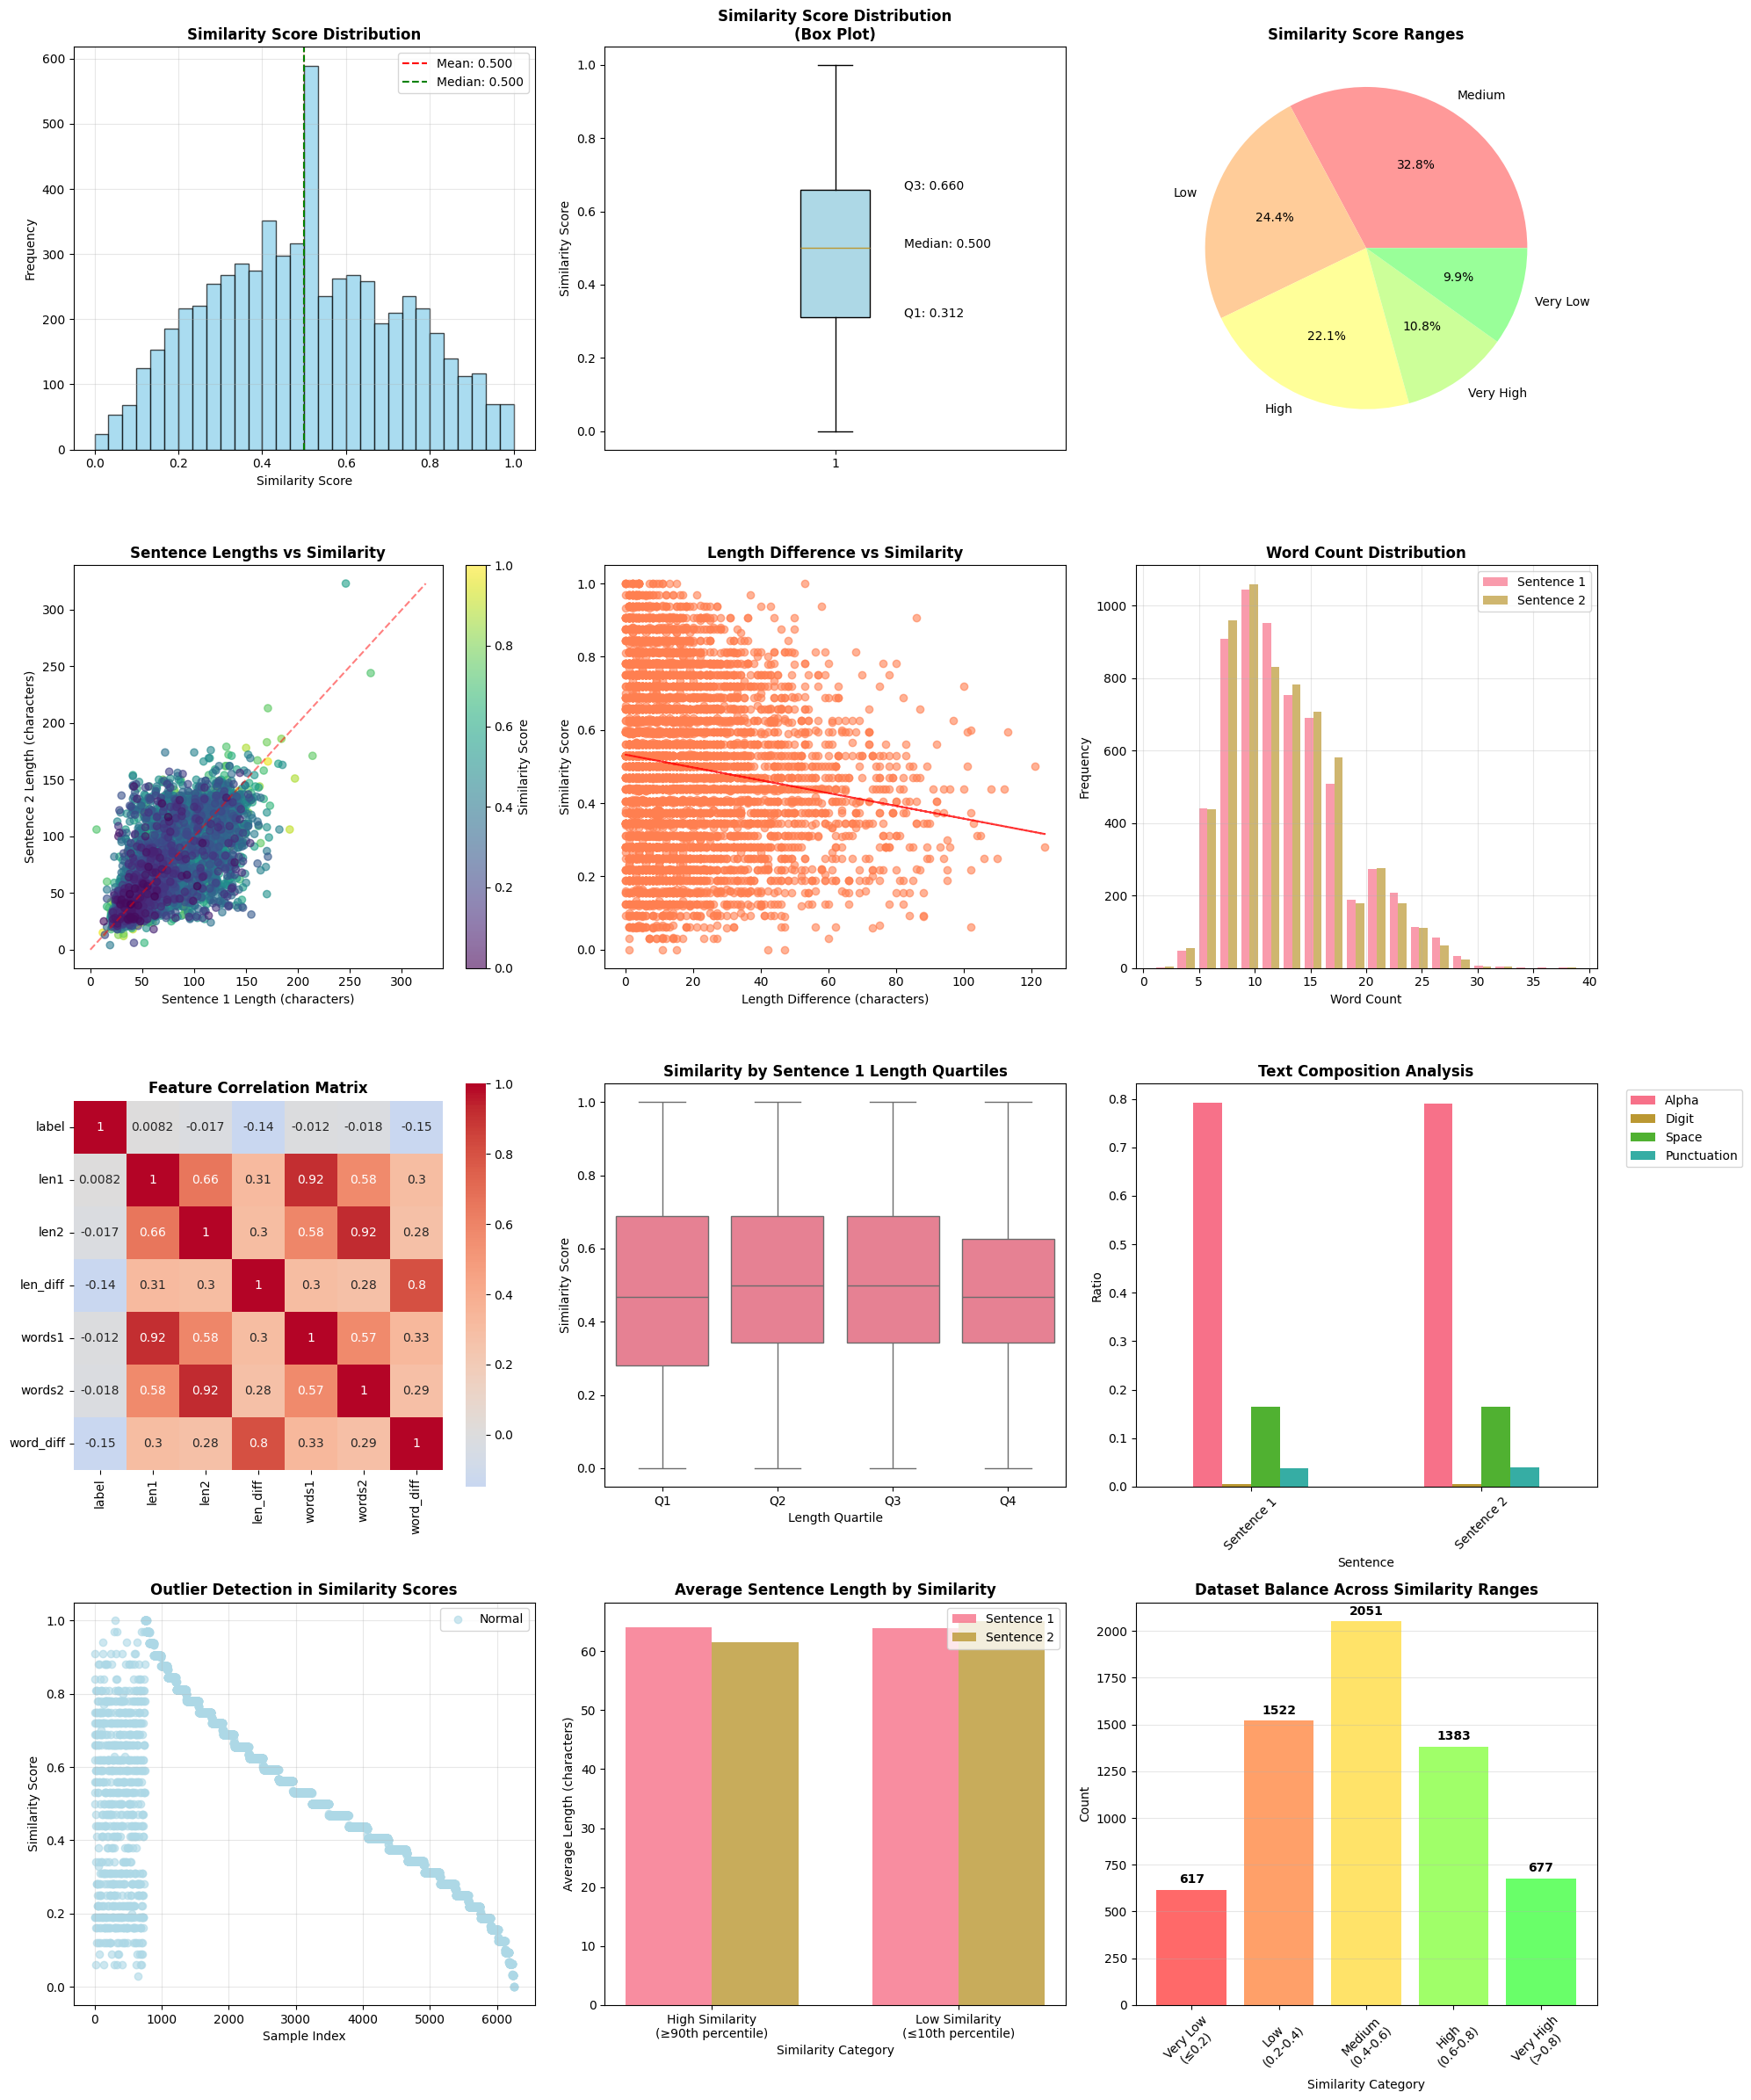


📈 DETAILED STATISTICS:
   Similarity Score Statistics:
      Mean: 0.5000
      Median: 0.5000
      Std Dev: 0.2227
      Skewness: 0.1065
      Kurtosis: -0.8220
      Range: 0.0000 to 1.0000

   Length Statistics:
      Avg Sentence 1 length: 72.5 chars (12.8 words)
      Avg Sentence 2 length: 72.0 chars (12.7 words)
      Avg length difference: 18.6 chars
      Max sentence length: 323 chars
      Min sentence length: 4 chars

   Data Quality Indicators:
      Outliers detected: 0 (0.0%)
      Empty sentences: 0
      Duplicate pairs: 1

   Key Correlations with Similarity Score:
      word_diff: -0.1475
      len_diff: -0.1418
      len2: -0.0173
      len1: 0.0082

   Dataset Balance:
      Very Low
(≤0.2): 617 samples (9.9%)
      Low
(0.2-0.4): 1522 samples (24.4%)
      Medium
(0.4-0.6): 2051 samples (32.8%)
      High
(0.6-0.8): 1383 samples (22.1%)
      Very High
(>0.8): 677 samples (10.8%)

🔍 SAMPLE PAIRS:

   HIGH Similarity Examples (score ≥ 0.875):
      Score: 0.910


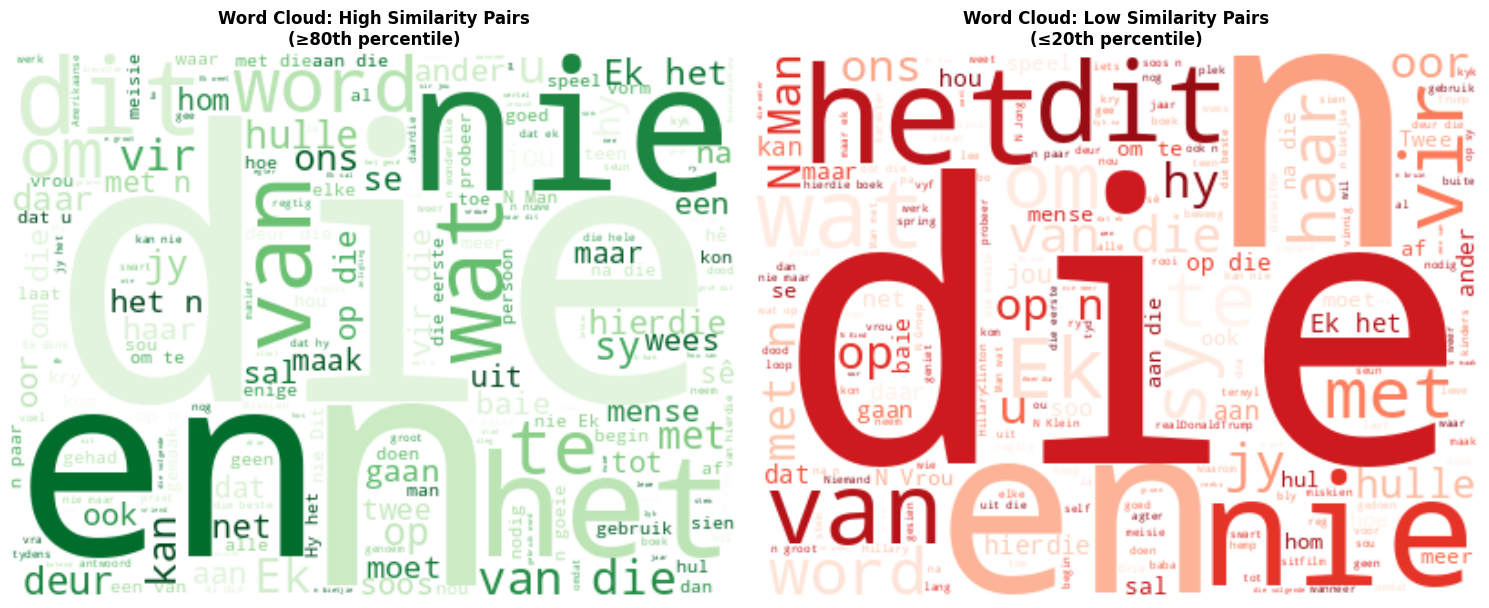


🎯 Generated seeds: [42]

🔄 Splitting dataset with seed 42:
   Train: 70.0%, Test: 30.0%
📊 Split Results:
   Train set: 4375 samples
   Test set: 1875 samples

🚀 Starting Run 1/1 (Seed: 42)
All seeds set to 42


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# EXECUTION INSTRUCTIONS FOR GOOGLE COLAB
# ============================================================================

print("""
🎯 READY TO RUN! Follow these steps:

1️⃣ UPLOAD YOUR DATA:
   - Upload 'cleaned.csv' to Colab (use the file browser on the left)
   - OR save it to Google Drive and mount the drive

2️⃣ RUN THE PIPELINE:
   Execute one of these commands:

   # Option A - File in current directory:
   model = run_complete_pipeline('cleaned.csv')

   # Option B - File in Google Drive (after mounting):
   model = run_complete_pipeline('/content/drive/MyDrive/path/to/cleaned.csv')

""")

# # Upload file
dataset_file = 'cleaned.csv'

# # Run complete pipeline
run_multiple_experiments(dataset_file, num_runs=NUM_RUNS, base_seed=BASE_SEED)